Calculation of rewards for the main branch. Currently all our mechs have the same main branch

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator
from auto_robot_design.pinokla.calc_criterion import (ActuatedMass, ImfCompute, ManipCompute,
                                                      MovmentSurface, NeutralPoseMass, TranslationErrorMSE, EffectiveInertiaCompute, ManipJacobian)
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import (convert_x_y_to_6d_traj_xz,
                                                    get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory)
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward
from auto_robot_design.optimization.rewards.inertia_rewards import EndPointIMFReward, MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point

#### Setup trajectories 

In [47]:
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.5, -1], step_height= 0.4, step_width=1,n_points=50))
left_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.65, -1], step_height= 0.4, step_width=1,n_points=50))
right_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.35, -1], step_height= 0.4, step_width=1,n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, 0,50))
left_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, -0.2,50))
right_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, 0.2,50))

#### Characteristics to be calculated

In [48]:
# criteria that either calculated without any reference to points, or calculated through
# the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}

crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

#### set the rewards and weights

In [49]:
rewards_step = [(PositioningReward(pos_error_key="POS_ERR"), 1), (AccelerationCapability(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass"), 1), (EndPointIMFReward(imf_key='IMF',
            trajectory_key="traj_6d", error_key="error"), 1)]

step_trajectories = [ground_symmetric_step,left_shift_step,right_shift_step]
rewards_vertical = [(PositioningReward(pos_error_key="POS_ERR"), 1),
           (HeavyLiftingReward(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", mass_key="MASS"), 1)]
vertical_trajectories = [central_vertical, left_vertical, right_vertical]

# rewards = [(PositioningReward(pos_error_key="POS_ERR"), 1),
#            (HeavyLiftingReward(manipulability_key='Manip_Jacobian',
#             trajectory_key="traj_6d", error_key="error", mass_key="MASS"), 1),
#            (AccelerationCapability(manipulability_key='Manip_Jacobian',
#             trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass"), 1),
#            (EndPointZRRReward(manipulability_key='Manip_Jacobian',
#             trajectory_key="traj_6d", error_key="error"), 1),
#            (VelocityReward(manipulability_key='Manip_Jacobian',
#             trajectory_key="traj_6d", error_key="error"), 1),
#            (EndPointIMFReward(imf_key='IMF',
#             trajectory_key="traj_6d", error_key="error"), 1),
#            (ForceEllipsoidReward(manipulability_key='Manip_Jacobian',
#             trajectory_key="traj_6d", error_key="error"), 1),
#            (MassReward(mass_key="MASS"), 1)
#            ]

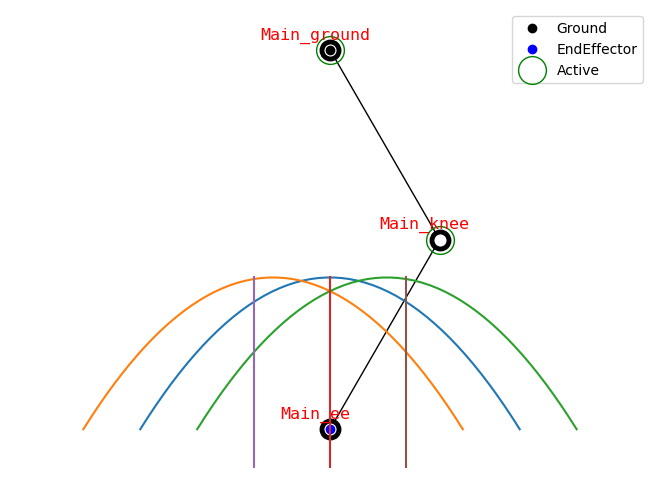

In [50]:
actuator_list = [TMotor_AK10_9(), TMotor_AK60_6(), TMotor_AK70_10(), TMotor_AK80_64(), TMotor_AK80_9()]
generator = TwoLinkGenerator()
generator.build_standard_two_linker()
graph = generator.graph
# open chain is fully actuated
for jp in graph.nodes:
    if not jp.attach_endeffector:
        jp.active = True

rewards_and_trajectories = [(rewards_step, step_trajectories),(rewards_vertical, vertical_trajectories)]


draw_joint_point(graph)



plt.plot(step_trajectories[0][:,[0]], step_trajectories[0][:,[2]])
plt.plot(step_trajectories[1][:,[0]], step_trajectories[1][:,[2]])
plt.plot(step_trajectories[2][:,[0]], step_trajectories[2][:,[2]])

plt.plot(vertical_trajectories[0][:,[0]], vertical_trajectories[0][:,[2]])
plt.plot(vertical_trajectories[1][:,[0]], vertical_trajectories[1][:,[2]])
plt.plot(vertical_trajectories[2][:,[0]], vertical_trajectories[2][:,[2]])


In [34]:
create_simple_step_trajectory(starting_point=[-0.5, -1.02], step_height= 0.4, step_width=1,n_points=50)
# np.transpose(ground_symmetric_step[:,[0,2]])

(array([-0.5       , -0.47959184, -0.45918367, -0.43877551, -0.41836735,
        -0.39795918, -0.37755102, -0.35714286, -0.33673469, -0.31632653,
        -0.29591837, -0.2755102 , -0.25510204, -0.23469388, -0.21428571,
        -0.19387755, -0.17346939, -0.15306122, -0.13265306, -0.1122449 ,
        -0.09183673, -0.07142857, -0.05102041, -0.03061224, -0.01020408,
         0.01020408,  0.03061224,  0.05102041,  0.07142857,  0.09183673,
         0.1122449 ,  0.13265306,  0.15306122,  0.17346939,  0.19387755,
         0.21428571,  0.23469388,  0.25510204,  0.2755102 ,  0.29591837,
         0.31632653,  0.33673469,  0.35714286,  0.37755102,  0.39795918,
         0.41836735,  0.43877551,  0.45918367,  0.47959184,  0.5       ]),
 array([-1.02      , -0.98801333, -0.95735943, -0.92803832, -0.90004998,
        -0.87339442, -0.84807164, -0.82408163, -0.80142441, -0.78009996,
        -0.76010829, -0.7414494 , -0.72412328, -0.70812995, -0.69346939,
        -0.68014161, -0.66814661, -0.65748438, -0

In [35]:
result_vector = {}
for j in actuator_list:
    # create builder
    thickness = 0.04
    builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
        [thickness*5, thickness*10, thickness*2]), actuator=j, thickness=thickness)

    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

    crag = CriteriaAggregator(
        dict_point_criteria, dict_trajectory_criteria)

    total_reward=0
    partial_rewards = []
    for rewards, trajectories in rewards_and_trajectories:
        max_reward = -float('inf')
        max_partial = None
        best_trajectory = None
        for trajectory_id, trajectory in enumerate(trajectories):
            point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
            current_total = 0
            current_partial = []
            for reward, weight in rewards:
                current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=j)[0])
                current_total += weight*current_partial[-1]
            if current_total > max_reward:
                max_reward = current_total
                max_partial = current_partial
                best_trajectory_id = trajectory_id
        total_reward+= max_reward
        partial_rewards.append((best_trajectory_id, max_partial))

    result_vector[j.__class__.__name__] = total_reward

print(result_vector)

{'TMotor_AK10_9': 53.31145833663592, 'TMotor_AK60_6': 11.819405600763535, 'TMotor_AK70_10': 31.89827021222476, 'TMotor_AK80_64': 94.59719611822595, 'TMotor_AK80_9': 22.859654246930074}
